# STEP 2 B: From categorical to One-Hot Vector and Segmentation and fold training

From categorical to One-Hot Vector dataset and segmentations of the different training "folds". In the section, we will compute the fold training instead of exporting the files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from utils.trainFoldB import train, saveColumnsToPartition

# Data Transformation

## Data Loading 

In [3]:
df = pd.read_csv('datasets/train_cleaned.csv', index_col='MachineIdentifier')

## Categorical Data Analysis 

In [4]:
columns_categorical = df.select_dtypes(include=['object']).columns

In [5]:
# Threshold of the size of different values of each categorical data
h_threshold = 350

In [6]:
total = 0
columns_to_partition = []
columns_to_onehot = []
for c in columns_categorical:
    values = df[c].nunique()
    suf = ""
    if (values > h_threshold):
        columns_to_partition.append(c)
        suf = ', PARTITION'
    else:
        columns_to_onehot.append(c)
    total += values
    print(c,': ',values,suf)
print('Total new vars: ' + str(total))

ProductName :  2 
EngineVersion :  57 
AppVersion :  101 
AvSigVersion :  6856 , PARTITION
Platform :  3 
Processor :  3 
OsVer :  33 
OsPlatformSubRelease :  9 
OsBuildLab :  418 , PARTITION
SkuEdition :  7 
SmartScreen :  16 
Census_MDC2FormFactor :  11 
Census_DeviceFamily :  3 
Census_PrimaryDiskTypeName :  4 
Census_ChassisTypeName :  40 
Census_PowerPlatformRoleName :  9 
Census_OSVersion :  359 , PARTITION
Census_OSArchitecture :  3 
Census_OSBranch :  15 
Census_OSEdition :  24 
Census_OSSkuName :  23 
Census_OSInstallTypeName :  9 
Census_OSWUAutoUpdateOptionsName :  5 
Census_GenuineStateName :  4 
Census_ActivationChannel :  5 
Census_FlightRing :  9 
Total new vars: 8028


## Segmentation and train

We are going to split the dataset based on the most scattered categorical variables  

In [7]:
columns_to_partition

['AvSigVersion', 'OsBuildLab', 'Census_OSVersion']

In [8]:
asvGB = df.groupby(columns_to_partition)['ProductName'].count()

In [9]:
# ... Maybe it is not a good idea to order this this way
#asvGB.sort_values(ascending=False, inplace=True)

In [10]:
asvGBdf=asvGB.to_frame()
asvGBdf.columns=['count']
asvGBdf.sort_index(level=[0,1,2],inplace=True)

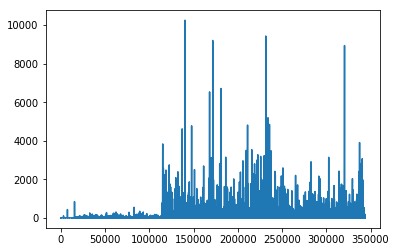

In [11]:
plt.plot(asvGBdf['count'].values)

Now, let's select indicators for each group and create a dictionary. Each group will have 200.000 elements aprox:

In [12]:
NE = 364000

In [13]:
asvGBDict = asvGBdf.to_dict()

In [14]:
acc = 0
f=1 # fold

foldDict = {}
for key, value in asvGBDict['count'].items():
    acc += value
    if (acc > NE):
        acc = 0
        f += 1
    foldDict[key]=f

In [15]:
def setFold(row):
    real_row = row.values
    return foldDict[(real_row[0],real_row[1],real_row[2])]

In [16]:
df['fold'] = df[columns_to_partition].apply(axis=1, func=setFold)

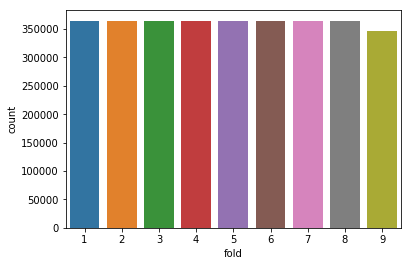

In [17]:
sns.countplot(data=df, x='fold')

We have all this folds to train, let's  get the different files with 50% of data to train the ensembled block:

In [18]:
nFolds = df['fold'].nunique()

In [ ]:
scores = []
lcurves = []
for i in range(nFolds):
    print('processing fold ',(i+1),' ... ')
    fold_df = df[df['fold']==(i+1)]
    columns_categorical = fold_df.select_dtypes(include=['object']).columns
    fold_df_num=pd.get_dummies(data=fold_df,columns=columns_categorical)    
    m=fold_df.shape[0]
    tm = int(m/2)
    ensemble_df = fold_df_num[0:tm]
    stack_df = fold_df[tm:]

    # Save columns to partition values
    saveColumnsToPartition(i+1, fold_df, columns_to_partition)
    
    # ensemble process
    ensemble_df.drop(labels=['fold'],axis=1,inplace=True)
    (score, lcurve) = train(i+1,ensemble_df)
    scores.append(score)
    lcurves.append(lcurve)
    
    # stacking process
    if (i == 0):
        stack_complete_df = stack_df.copy()
    else:
        stack_complete_df = pd.concat([stack_complete_df, stack_df])

processing fold  1  ... 


/opt/conda/envs/dsbase/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Initiating training of fold 1 ...
X size:(181945, 6861)
y size:(181945,)
initiating model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


training model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


saving model: models/fold1/AdaBoostClassification_AB2.sav
Training of fold 1 finalized!
processing fold  2  ... 


/opt/conda/envs/dsbase/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Initiating training of fold 2 ...
X size:(182212, 962)
y size:(182212,)
initiating model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


training model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


saving model: models/fold2/AdaBoostClassification_AB2.sav
Training of fold 2 finalized!
processing fold  3  ... 


/opt/conda/envs/dsbase/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Initiating training of fold 3 ...
X size:(181948, 962)
y size:(181948,)
initiating model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


training model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


saving model: models/fold3/AdaBoostClassification_AB2.sav
Training of fold 3 finalized!
processing fold  4  ... 


/opt/conda/envs/dsbase/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Initiating training of fold 4 ...
X size:(182170, 958)
y size:(182170,)
initiating model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


training model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


saving model: models/fold4/AdaBoostClassification_AB2.sav
Training of fold 4 finalized!
processing fold  5  ... 


/opt/conda/envs/dsbase/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Initiating training of fold 5 ...
X size:(182073, 931)
y size:(182073,)
initiating model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


initiating model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


training model AB0. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB1. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


training model AB2. AdaBoostClassification


/opt/conda/envs/dsbase/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
stack_complete_df.to_csv('datasets/train_stack.csv')

## Show the results of the training of each fold 

In [ ]:
def showFoldModelInfo(fold_id):
    print('scoring: ',str(scores[i-1]))
    plt.plot(lcurves[i-1][0,:],'b',lcurves[i-1][1,:],'r')

In [ ]:
showFoldModelInfo(1)

In [ ]:
showFoldModelInfo(2)

In [ ]:
showFoldModelInfo(3)

In [ ]:
showFoldModelInfo(4)

In [ ]:
showFoldModelInfo(5)

In [ ]:
showFoldModelInfo(6)

In [ ]:
showFoldModelInfo(7)

In [ ]:
showFoldModelInfo(8)

In [ ]:
showFoldModelInfo(9)

# End of Analisys! 

After this execution we have the "folded" models and the "stacking" dataset!